In [ ]:
import networkx as nx 
import pandas as pd
import matplotlib.pyplot as plt

## Some terminology

User looking for recommendation: **Main user** <br/>
Other users: **Other users/ users**

## Finding relations between users 

We will generate relationships (weights) between the main user and other users. The suggestions/ratings of a user having a better relationship with main user will have more weightage over that of other users. <br />
The relationship will be denotated by a directed edge from the main user to the other user.

In [29]:
def relationship_among_users(G, user, deg):
    '''
        description:
            given main user, add weighted edges between 
            main user and other users based on common nodes
    
        parameters:
            G: the bipartite graph (directed, weighted)
            user: user who is looking for recommendations (main user)
            deg: no. of anime main user has reviwed

        returns: 
            void
    '''

    u = user

    for w in users:
        weight = 0.0
        for v in G.neighbors(u): 
            if G.nodes[v]['label'] == 'anime' and G.has_edge(w, v):
                weight += (1/G.out_degree(v))

        weight /= deg

        if (weight != 0):
            G.add_edge(u, w, weight=weight) 

## Recommended anime list

Based on main user's relationships and the ratings given to anime by other users, a list of anime_ids is returned in sorted order (most recommended anime first)

In [58]:
def recommendation_list(G, user, deg, include_already_watched=False):
    '''
        description: 
            Given a graph with connections (weghted, directed) among users
            and the user who needs recommendations,
            returns sorted list of recommended animes 

        parameters:
            G: Graphs with connection among users 
                (graph after implementing 'relationship_among_users()')
            user: User who is looking for recommendations (main user)
            deg: number of anime main user has reviewed
            include_already_watched: (default = false)
                if true, the list of anime main user has already watched will 
                also be included in the recommendation list

        returns: 
            sorted list of recommended anime
                eg. [(anime1, score1), (anime2, score2), (anime3, score3)]
    '''

    u = user
    possible_anime = set()

    for n in G.neighbors(u):
        if G.nodes[n]['label'] == 'anime':
            for other_users in G.neighbors(n):
                for anime in G.neighbors(other_users):
                    if G.nodes[anime]['label'] == 'anime':
                        possible_anime.add(anime)

    suggestion_list = {}

    for anime in possible_anime:
        # print('===================================')
        # print(anime)
        score = 0
        for w in G.neighbors(anime):
            if G.has_edge(u, w):
                # print(w)
                # print(G[u][w]['weight'])
                # print(G[w][anime]['rating'])
                score += (G[u][w]['weight'] * G[w][anime]['rating'] / (deg if w==u else G.out_degree(w)))

        # print('===================================')
        
        suggestion_list[anime] = score

    return (sorted(list(suggestion_list.items()), key=(lambda x : x[1]), reverse=True))


## Fetch anime title

Based on the ids returned in 'recommendation_list()' function, the respective anime titles and plots are returned.

# Testing

Let us try the above algorithms over a small network to understand how it works.

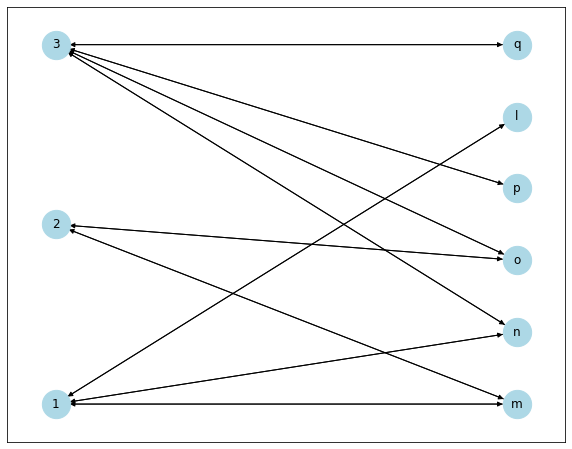


weights among users: {(2, 1): 0.25, (2, 2): 0.5, (2, 3): 0.25}



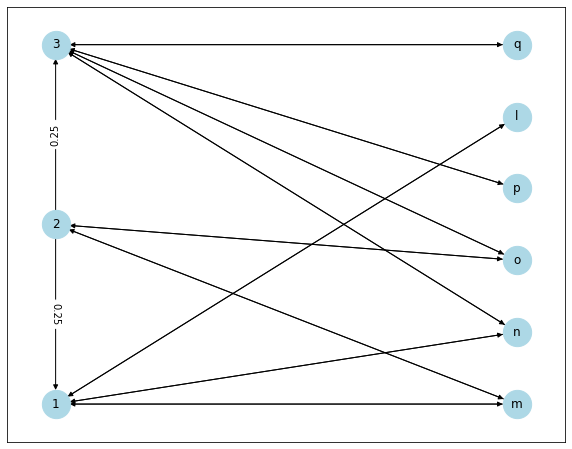


Recommended list of anime ids: [('m', 1.6666666666666667), ('o', 1.5625), ('n', 0.7291666666666667), ('l', 0.4166666666666667), ('p', 0.3125), ('q', 0.3125)]



In [59]:
G = nx.Graph()

users = [1,2,3]
anime = ['l','m','n','o','p','q']

G.add_nodes_from(users, label='user')
G.add_nodes_from(anime, label='anime')
G.add_edges_from([(1, 'l', {'rating' : 5}), 
                  (1, 'm', {'rating' : 5}),
                  (1, 'n', {'rating' : 5}),
                  (2, 'm', {'rating' : 5}),
                  (2, 'o', {'rating' : 5}),
                  (3, 'n', {'rating' : 5}),
                  (3, 'o', {'rating' : 5}),
                  (3, 'p', {'rating' : 5}),
                  (3, 'q', {'rating' : 5})])

main_user = 2
deg = G.degree(main_user)

G = nx.DiGraph(G)

pos = nx.bipartite_layout(G, users)

plt.figure(figsize=(10, 8))
nx.draw_networkx(G, pos=pos, node_size=800, node_color='lightblue')
plt.show()

# generating relationships among users
relationship_among_users(G, main_user, deg)

edge_weights = nx.get_edge_attributes(G, 'weight')
print('\n===================================')
print('weights among users:', edge_weights)
print('===================================\n')

plt.figure(figsize=(10, 8))
nx.draw_networkx(G, pos=pos, node_size=800, node_color='lightblue')
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_weights)
plt.show()

#getting the recommended list of anime ids
recommended_anime_ids = recommendation_list(G, main_user, deg)

print('\n===================================')
print('Recommended list of anime ids:', recommended_anime_ids)
print('===================================\n')


## Actual data

Lets try it on our actual data now.

dataset: https://www.kaggle.com/hernan4444/anime-recommendation-database-2020?select=rating_complete.csv

In [84]:
data = pd.read_csv('rating_complete.csv', nrows=5000)
data['anime_id'] = 'a' + data['anime_id'].astype(int).astype(str)
data_users = data['user_id']
data_anime = data['anime_id']

In [85]:
data.head()

,user_id,anime_id,rating
0,0,a430,9
1,0,a1004,5
2,0,a3010,7
3,0,a570,7
4,0,a2762,9


In [86]:
G = nx.Graph()
G = nx.from_pandas_edgelist(data, 'user_id', 'anime_id', edge_attr='rating')

G.add_nodes_from(data_users, label='user')
G.add_nodes_from(data_anime, label='anime')

main_user = 2
deg = G.degree(main_user)

G = nx.DiGraph(G)

## plotting the graph takes a lot of time

# pos = nx.bipartite_layout(G, users)

# plt.figure(figsize=(50, 40))
# # nx.draw_networkx(G, pos=pos, node_size=100, node_color='lightblue', edge_color='grey' with_labels=False)
# nx.draw_networkx(G, node_size=100, node_color='lightblue', edge_color='grey', with_labels=False)
# plt.show()


51


In [87]:
# generating relationships among users
relationship_among_users(G, main_user, deg)

edge_weights = nx.get_edge_attributes(G, 'weight')
print('\n===================================')
print('weights among users:', edge_weights)
print('===================================\n')

# plt.figure(figsize=(10, 8))
# nx.draw_networkx(G, pos=pos, node_size=800, node_color='lightblue')
# nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_weights)
# plt.show()

#getting the recommended list of anime ids
recommended_anime_ids = recommendation_list(G, user=main_user, deg=deg)

print('\n===================================')
print('Recommended list of anime ids:', recommended_anime_ids)
print('===================================\n')


weights among users: {(2, 1): 0.039309362201367305, (2, 2): 0.35265119466084666, (2, 3): 0.04248260710198426, (2, 4): 0.00868713498471284, (2, 5): 0.0015082956259426848, (2, 6): 0.011895381846210475, (2, 7): 0.010735234264646029, (2, 8): 0.0015082956259426848, (2, 11): 0.017984808988269194, (2, 12): 0.011172322386126794, (2, 13): 0.0011534025374855825, (2, 14): 0.04581395152329408, (2, 16): 0.03767759015437033, (2, 17): 0.06151362852328068, (2, 18): 0.0052772743084161765, (2, 19): 0.050885968446522094, (2, 20): 0.034201436678216866, (2, 21): 0.042683167045760376, (2, 22): 0.0028011204481792717, (2, 23): 0.014552729085601058, (2, 25): 0.019926369926369925, (2, 27): 0.013699914619601381, (2, 28): 0.010169221296520514, (2, 29): 0.026880816122302188, (2, 30): 0.01876590783438352, (2, 32): 0.013007489013680965, (2, 33): 0.003210640981538814, (2, 34): 0.010769546896846113, (2, 36): 0.01586650245819796, (2, 37): 0.00218539428155163, (2, 38): 0.027633658051614707, (2, 40): 0.00938937510144940